In [1]:
import sys
sys.path.append("../src")

In [2]:
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.utils.dtcc_swaps_utils import datetime_to_ql_date, tenor_to_ql_period, format_swap_time_and_sales, build_ql_piecewise_curves
from datetime import datetime
import pandas.tseries.offsets as offsets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.optimize import brentq
import scipy.interpolate
import rateslib as rl
import QuantLib as ql
import plotly.graph_objects as go
from termcolor import colored
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from typing import Dict, List, Optional, Tuple
import urllib.parse
import requests
import pickle
import os
import shelve

from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Project Bond King\Curvy-CUSIPs\notebooks\../.env


In [8]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"], error_verbose=True, debug_verbose=True)

2024-11-19 11:51:33,298 - CurvyCUSIPs.DataFetcher.base - DEBUG - UST Auctions - Number of Links to Fetch: 2
2024-11-19 11:51:33,299 - CurvyCUSIPs.DataFetcher.base - DEBUG - UST Auctions - Links: ['https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query?page[number]=1&page[size]=10000', 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query?page[number]=2&page[size]=10000']


BUILDING SOFR CURVES...: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


,Tenor,Expiry,Open,High,Low,Close,VWAP
0,1D,2024-11-21,0.046152,0.046152,0.046206,0.046204,0.046190
1,1W,2024-11-27,0.046091,0.046091,0.046139,0.046138,0.046125
2,2W,2024-12-04,0.046020,0.046020,0.046062,0.046060,0.046050
3,3W,2024-12-11,0.045948,0.045948,0.045984,0.045983,0.045974
4,1M,2024-12-20,0.045854,0.045854,0.045881,0.045880,0.045873
5,2M,2025-01-21,0.045545,0.045545,0.045545,0.045545,0.045545
6,3M,2025-02-20,0.045236,0.045236,0.045209,0.045210,0.045217
7,4M,2025-03-20,0.044917,0.044933,0.044898,0.044912,0.044913
8,5M,2025-04-21,0.044597,0.044629,0.044588,0.044613,0.044609
9,6M,2025-05-20,0.044277,0.044325,0.044277,0.044315,0.044304


,Event timestamp,Execution Timestamp,Effective Date,Expiration Date,Platform identifier,Tenor,Fwd,Fixed Rate,Direction,Notional Amount,Unique Product Identifier,UPI FISN,UPI Underlier Name
0,2024-11-18 00:26:50,2024-11-18 00:26:50,2025-03-19,2045-03-19,TWSF,20Y,3M,0.034002,receive,7000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
1,2024-11-18 00:51:04,2024-11-18 00:51:04,2024-11-20,2025-02-20,BMTF,3M,0D,0.045144,receive,400000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
2,2024-11-18 01:04:01,2024-11-18 01:04:01,2024-11-20,2054-11-20,BBSF,30Y,0D,0.037765,receive,3000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
3,2024-11-18 01:19:12,2024-11-18 01:19:12,2024-11-20,2034-11-20,BBSF,10Y,0D,0.039215,receive,5000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
4,2024-11-18 01:29:55,2024-11-18 01:29:55,2024-11-20,2054-11-20,BBSF,30Y,0D,0.037761,receive,3000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2024-11-18 21:42:30,2024-11-18 21:42:30,2024-11-20,2044-11-20,BBSF,20Y,0D,0.039356,receive,9000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
531,2024-11-18 21:44:45,2024-11-18 21:44:45,2024-11-20,2027-01-19,BBSF,2Y,0D,0.040545,receive,370000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
532,2024-11-18 21:46:52,2024-11-18 21:46:52,2024-11-20,2026-08-22,BBSF,21M,0D,0.040989,receive,300000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND
533,2024-11-18 21:55:21,2024-11-18 21:55:21,2022-11-25,2032-11-25,BBSF,10Y,-726D,0.034672,receive,8000000,QZXQ4R16245X,NA/Swap OIS USD,USD-SOFR-COMPOUND


{'logLinearDiscount': <QuantLib.QuantLib.PiecewiseLogLinearDiscount; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLogLinearDiscount > *' at 0x000002E68A64E1F0> >,
 'logCubicDiscount': <QuantLib.QuantLib.PiecewiseLogCubicDiscount; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLogCubicDiscount > *' at 0x000002E68A63BAE0> >,
 'linearZero': <QuantLib.QuantLib.PiecewiseLinearZero; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLinearZero > *' at 0x000002E68A75A0A0> >,
 'cubicZero': <QuantLib.QuantLib.PiecewiseCubicZero; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseCubicZero > *' at 0x000002E68A6382D0> >,
 'linearForward': <QuantLib.QuantLib.PiecewiseLinearForward; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseLinearForward > *' at 0x000002E68A63AB80> >,
 'splineCubicDiscount': <QuantLib.QuantLib.PiecewiseSplineCubicDiscount; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseSplineCubicDiscount > *' at 0x000002E68A6389C0> >}

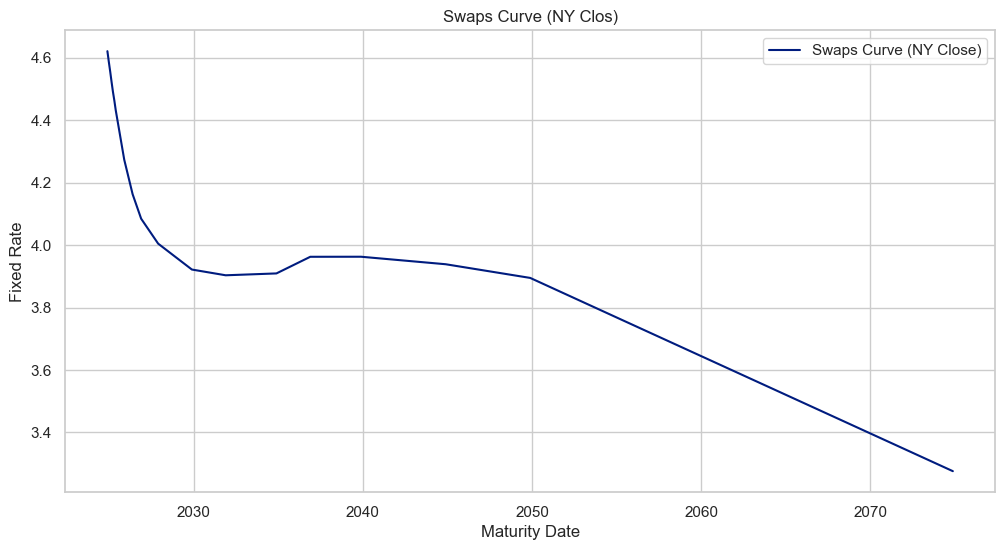

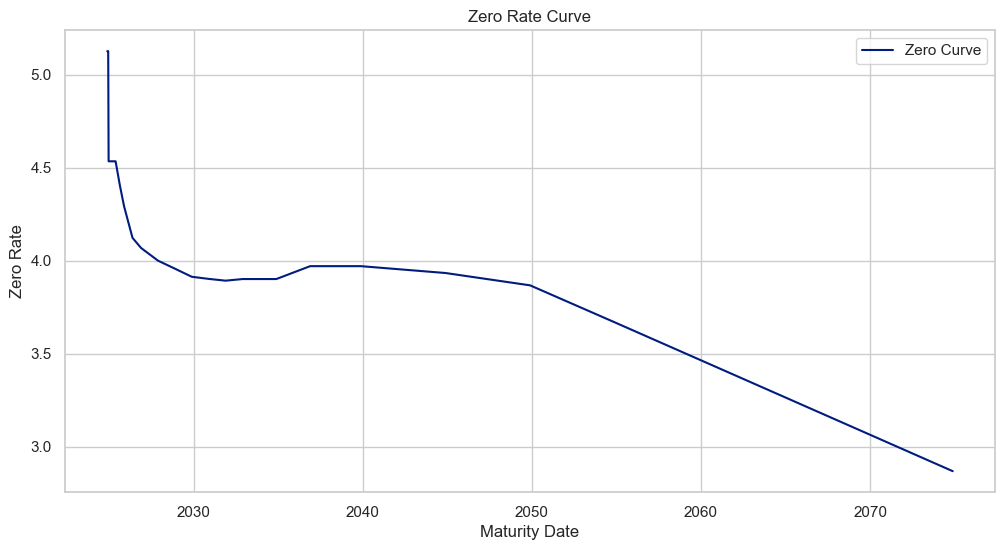

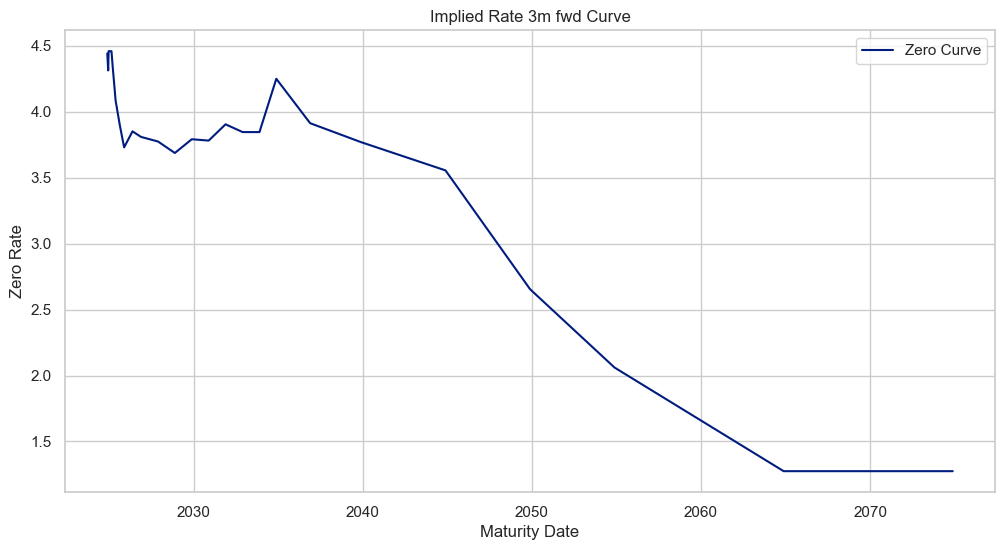

In [302]:
# https://www.jpmorgan.com/content/dam/jpm/global/disclosures/IN/usd-inr-irs.pdf

as_of_date = datetime(2024, 11, 18)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count = ql.Actual360()
fixing_lag = 1

swaps_dict = curve_data_fetcher.dtcc_sdr_fetcher.fetch_historical_swaps_term_structure(
    start_date=as_of_date,
    end_date=as_of_date,
    swap_type="Fixed_Float_OIS",
    # reference_floating_rates=["USD-SOFR-COMPOUND", "USD-SOFR-OIS Compound"],
    reference_floating_rates=["USD-SOFR-COMPOUND"],
    ccy="USD",
    reference_floating_rate_term_value=1,
    reference_floating_rate_term_unit="DAYS",
    notional_schedule="Constant",
    delivery_types=["CASH", "PHYS"],
    tenor_col="Tenor",
    fixed_rate_col="Close",
    settlement_t_plus=2,
    payment_lag=2,
    ql_index=ql.OvernightIndex(
        "SOFR",
        fixing_lag,
        ql.USDCurrency(),
        calendar,
        day_count,
        ql.YieldTermStructureHandle()
    ),
    fixed_leg_frequency=ql.Annual,
    fixed_leg_daycount=day_count,
    fixed_leg_convention=ql.ModifiedFollowing,
    fixed_leg_calendar=calendar,
    logLinearDiscount=True,
    logCubicDiscount=True,
    linearZero=True,
    cubicZero=True,
    linearForward=True,
    splineCubicDiscount=True,
    ny_hours_only=True,
    filter_extreme_time_and_sales=True,
    # verbose=True
)

display(swaps_dict[as_of_date]["ohlc"])
display(swaps_dict[as_of_date]["time_and_sales"])
display(swaps_dict[as_of_date]["ql_curves"])

test_ql_curve = swaps_dict[as_of_date]["ql_curves"]["logLinearDiscount"]
test_ql_curve.enableExtrapolation()
expiry_dates = swaps_dict[as_of_date]["ohlc"]["Expiry"].dt.to_pydatetime()

plt.figure(figsize=(12, 6))
plt.plot(expiry_dates, swaps_dict[as_of_date]["ohlc"]["Close"] * 100, label="Swaps Curve (NY Close)")
plt.title("Swaps Curve (NY Clos)")
plt.xlabel("Maturity Date")
plt.ylabel("Fixed Rate")
plt.grid(True)
plt.legend()
plt.show()

zero_rates = [
    test_ql_curve.zeroRate(datetime_to_ql_date(maturity), ql.Actual360(), ql.Compounded, ql.Annual).rate() * 100 for maturity in expiry_dates
]

plt.figure(figsize=(12, 6))
plt.plot(expiry_dates, zero_rates, label="Zero Curve")
plt.title("Zero Rate Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

fwd_rates = [
    test_ql_curve.forwardRate(datetime_to_ql_date(date), datetime_to_ql_date(date) + tenor_to_ql_period("3M"), ql.Actual360(), ql.Simple).rate()
    * 100
    for date in expiry_dates
]
plt.figure(figsize=(12, 6))
plt.plot(expiry_dates, fwd_rates, label="Zero Curve")
plt.title("Implied Rate 3m fwd Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

In [299]:
ts_df = swaps_dict[as_of_date]["time_and_sales"]
ts_df[(ts_df["Fwd"] == "1D") & (ts_df["Tenor"] == "10Y")]

,Event timestamp,Execution Timestamp,Effective Date,Expiration Date,Platform identifier,Tenor,Fwd,Fixed Rate,Direction,Notional Amount,Unique Product Identifier,UPI FISN,UPI Underlier Name
13,2023-10-06 01:56:19,2023-10-06 01:56:19,2023-10-11,2033-10-11,BBSF,10Y,1D,0.044126,pay,2000000.0,DNE,DNE,USD-SOFR-COMPOUND
30,2023-10-06 05:11:31,2023-10-06 05:11:31,2023-10-11,2033-10-11,TREU,10Y,1D,0.044132,receive,5000000.0,DNE,DNE,USD-SOFR-COMPOUND
35,2023-10-06 05:54:34,2023-10-06 05:54:34,2023-10-11,2033-10-11,BBSF,10Y,1D,0.044190,receive,50000000.0,DNE,DNE,USD-SOFR-COMPOUND
36,2023-10-06 05:55:17,2023-10-06 05:55:17,2023-10-11,2033-10-11,BBSF,10Y,1D,0.044199,receive,50000000.0,DNE,DNE,USD-SOFR-COMPOUND
37,2023-10-06 05:55:59,2023-10-06 05:55:59,2023-10-11,2033-10-11,BBSF,10Y,1D,0.044199,receive,50000000.0,DNE,DNE,USD-SOFR-COMPOUND
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2023-10-06 20:05:16,2023-10-06 20:05:16,2023-10-11,2033-10-11,TWSF,10Y,1D,0.044840,receive,130000000.0,DNE,DNE,USD-SOFR-COMPOUND
768,2023-10-06 20:57:15,2023-10-06 20:57:15,2023-10-11,2033-10-11,TWSF,10Y,1D,0.044905,receive,25000000.0,DNE,DNE,USD-SOFR-COMPOUND
769,2023-10-06 20:58:26,2023-10-06 20:58:26,2023-10-11,2033-10-11,TWSF,10Y,1D,0.044922,receive,2000000.0,DNE,DNE,USD-SOFR-COMPOUND
770,2023-10-06 20:58:47,2023-10-06 20:58:47,2023-10-11,2033-10-11,TWSF,10Y,1D,0.044925,receive,23000000.0,DNE,DNE,USD-SOFR-COMPOUND


In [264]:
sdr_time_and_sales = curve_data_fetcher.dtcc_sdr_fetcher.fetch_dtcc_sdr_data_timeseries(start_date=as_of_date, end_date=as_of_date, agency="CFTC", asset_class="RATES")
sdr_time_and_sales_df = sdr_time_and_sales[as_of_date]
sdr_time_and_sales_df[sdr_time_and_sales_df["Unique Product Identifier"] == "QZXQ4R16245X"]

FETCHING DTCC SDR DATASETS...: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


KeyError: 'Unique Product Identifier'

In [44]:
ql_discount_factor_curve_from_loaded = {}
with shelve.open(r"C:\Users\chris\Project Bond King\ql_swap_curve_objs\nyc_sofr_ois_curve_builds_master") as db:
    for curr_date in [datetime(2024, 11, 15)]:
        loaded_ql_nodes_dict: Dict = db[str(int(curr_date.timestamp()))]["splineCubicDiscount"]
        ql_discount_factor_curve_from_loaded[curr_date] = ql.DiscountCurve(
            [datetime_to_ql_date(mat) for mat in loaded_ql_nodes_dict.keys()],
            loaded_ql_nodes_dict.values(),
            ql.Actual360(),
            ql.UnitedStates(ql.UnitedStates.FederalReserve),
        )

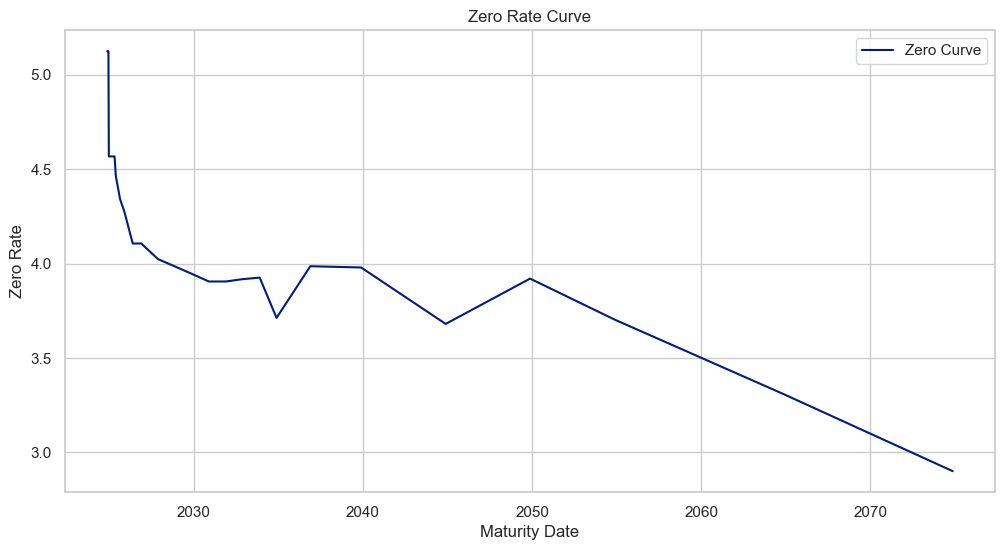

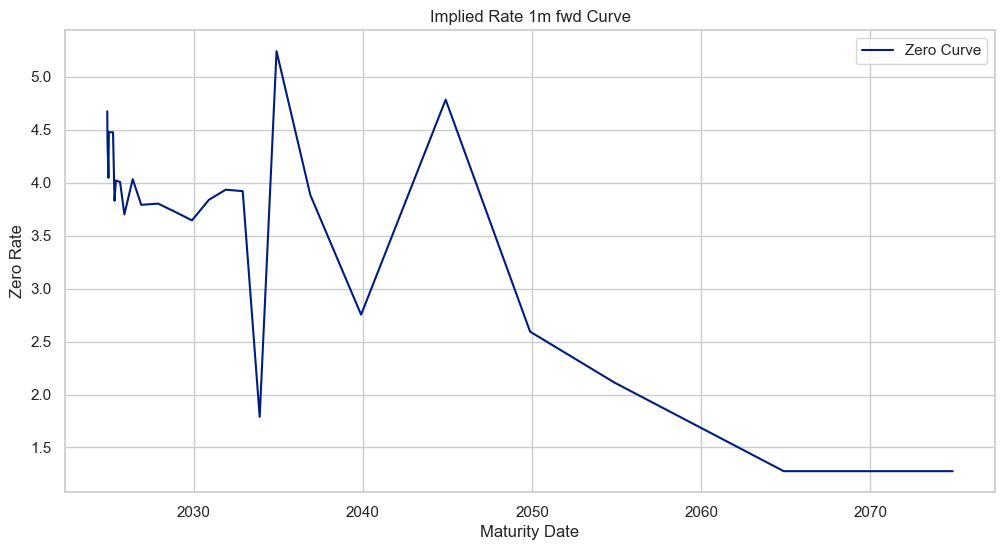

In [45]:
test_date = datetime(2024, 11, 15) 
loaded_ql_df_curve: ql.DiscountCurve = ql_discount_factor_curve_from_loaded[test_date]
loaded_ql_df_curve.enableExtrapolation()

expiry_dates = [datetime(node[0].year(), node[0].month(), node[0].dayOfMonth()) for node in loaded_ql_df_curve.nodes()]

zero_rates = [
    loaded_ql_df_curve.zeroRate(datetime_to_ql_date(maturity), ql.Actual360(), ql.Compounded, ql.Annual).rate() * 100 for maturity in expiry_dates
]

plt.figure(figsize=(12, 6))
plt.plot(expiry_dates, zero_rates, label="Zero Curve")
plt.title("Zero Rate Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

fwd_rates = [
    loaded_ql_df_curve.forwardRate(datetime_to_ql_date(date), datetime_to_ql_date(date) + tenor_to_ql_period("1M"), ql.Actual360(), ql.Simple).rate()
    * 100
    for date in expiry_dates
]
plt.figure(figsize=(12, 6))
plt.plot(expiry_dates, fwd_rates, label="Zero Curve")
plt.title("Implied Rate 1m fwd Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

In [139]:
curr_curve = sofr_ois_term_structures[test_date][0]["NelsonSiegelFitting"]
curr_curve.enableExtrapolation()

ts_df, scipy_interp_dict= build_sofr_ois_term_structure_df(
    df=sofr_ois_term_structures[start_date][0],
    as_of_date=start_date,
    fixed_rate_col="Close",
    curve=curr_curve,
    fwd_rate_tenors=["1M", "3M", "6M", "12M"],
)
ts_df

plt.figure(figsize=(12, 6))
plt.plot(ts_df["Expiry"], ts_df["Zero Rate"], label="Zero Curve")
plt.title("Zero Rate Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(ts_df["Expiry"], ts_df["1M Fwd"], label="Fwd Curve")
plt.title("Implied Rate 1m fwd Curve")
plt.xlabel("Maturity Date")
plt.ylabel("Zero Rate")
plt.grid(True)
plt.legend()
plt.show()

KeyError: 0

In [937]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_df["Expiry"], y=ts_df["Fixed Rate"], mode="lines", name="Fixed Rate"))
fig.add_trace(go.Scatter(x=ts_df["Expiry"], y=ts_df["1M Fwd"], mode="lines", name="1M Fwd"))
fig.add_trace(go.Scatter(x=ts_df["Expiry"], y=ts_df["3M Fwd"], mode="lines", name="3M Fwd"))
fig.update_layout(title="SOFR OIS Swaps", xaxis_title="Tenor", yaxis_title="Yields", template="plotly_dark", height=700)
fig.update_xaxes(
    showgrid=True,
    showspikes=True,
    spikecolor="white",
    spikesnap="cursor",
    spikemode="across",
)
fig.update_yaxes(showgrid=True, showspikes=True, spikecolor="white", spikesnap="cursor", spikethickness=0.5)
fig.show()